In [1]:
import numpy as np
import pandas as pd
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
!pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D

  Cloning https://github.com/shijianjian/EfficientNet-PyTorch-3D to /tmp/pip-req-build-gjfvjr4z
  Running command git clone -q https://github.com/shijianjian/EfficientNet-PyTorch-3D /tmp/pip-req-build-gjfvjr4z
  Resolved https://github.com/shijianjian/EfficientNet-PyTorch-3D to commit 3e79bcd06216b2e831bf3300fff9636cce2cd0d1
  Created wheel for efficientnet-pytorch-3d: filename=efficientnet_pytorch_3d-0.6.3-py3-none-any.whl size=16770 sha256=10b59a4ee6c4bdcb39fed6eb33ae19bac9361e1c2b406423271f31cb3aa31cb9
  Stored in directory: /tmp/pip-ephem-wheel-cache-dldz4wjy/wheels/ea/44/3d/89ce0e32ed262cff6c10d0586dc8f82bbb8ba1eeb47863abe5
Successfully built efficientnet-pytorch-3d


In [2]:
train_csv = pd.read_csv('/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
train_csv

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


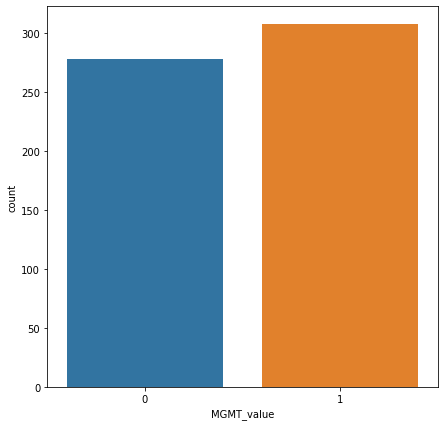

In [3]:
plt.figure(figsize=(7, 7))
sns.countplot(data=train_csv, x="MGMT_value");

In [4]:
NUM_IMAGES = 64
mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 256

#https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way

def load_dicom(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    #normalise data 0-255
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

#loads 64 (SIZE) images from a DICOM file from a single MRI type
def load_dicom_3d(brats21id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", data_split="train"):
    patient_path = os.path.join("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/", str(brats21id).zfill(5))
    x = glob.glob(os.path.join(patient_path, mri_type, "*"))
    paths = sorted(glob.glob(os.path.join(patient_path, mri_type, "*")), key=lambda x: int(x[:-4].split("-")[-1]))
    middle = len(paths) // 2
    num_imgs2 = num_imgs // 2
    bottom = max(0, middle - num_imgs2)
    top = min(len(paths), middle + num_imgs2)
    image_3d = np.stack([load_dicom(f) for f in paths[bottom:top]]).T 
    
    #pad with zeroes in case there are less than SIZE images in the dicom
    if image_3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - image_3d.shape[-1]))
        image_3d = np.concatenate((img3d,  n_zero), axis = -1)
    
    #normalise data
    if np.min(image_3d) < np.max(image_3d):
        image_3d = image_3d - np.min(image_3d)
        image_3d = image_3d / np.max(image_3d)
            
    return np.expand_dims(image_3d, 0)

In [5]:
# Displays the middle sample of each MRI type for an ID
def visualise_sample(brats21id, mgmt_value, types=("FLAIR", "T1w", "T1wCE", "T2w")):
    plt.figure(figsize=(16, 5)) 
    patient_path = os.path.join("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/", str(brats21id).zfill(5))
    for i, type in enumerate(types, 1):
        x = glob.glob(os.path.join(patient_path, type, "*"))
        type_paths = sorted(glob.glob(os.path.join(patient_path, type, "*")), key=lambda x: int(x[:-4].split("-")[-1]))
        data = load_dicom(type_paths[(len(type_paths) // 2)])

        plt.subplot(1, 4, i)
        plt.imshow(data, cmap="gray")
        plt.title(f"{type}", fontsize=16)

    plt.suptitle(f"BraTS21ID: {brats21id}  MGMT_value: {mgmt_value}", fontsize=16)
    plt.show()

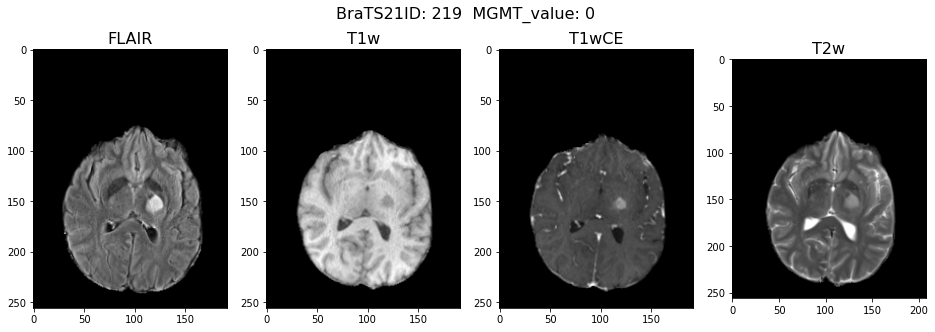

In [6]:
random_sample = train_csv.sample(n=1).values
random_sample_ID = random_sample[0][0]
random_sample_MGMT = random_sample[0][1]
visualise_sample(random_sample_ID, random_sample_MGMT)

In [7]:
efficientnet_path = "../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D"

from efficientnet_pytorch_3d import EfficientNet3D

import torch
from torch import nn

#dataset splitting
from sklearn import model_selection as sk_model_selection

#convolutional
from torch.nn import functional as torch_functional

In [8]:
train, valid = sk_model_selection.train_test_split(train_csv, random_state=322, stratify=train_csv["MGMT_value"],)

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_IDs, targets, mri_type):
        self.image_IDs = image_IDs
        self.targets = targets
        self.mri_type = mri_type
        
    def __len__(self):
        return len(self.image_IDs)
    
    def __getitem__(self, i):
        image_num = image_IDs[i]
        data = load_dicom_3d(image_id, mri_type=self.mri_type[index])